In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from itertools import combinations
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import make_classification
import seaborn as sns

In [2]:
def sigmoid(w,b,x):
    wx = (x*w).sum(1) +b
    return 1/(1+np.exp(-wx))

def sample(p):
    return (np.random.random(len(p))<=p).astype(int)

In [3]:
class ModelData:
    def __init__(self, N,d,T, noise_scale = 0.1):
        self.N = N
        self.d = d
        self.T = T
        self.noise_scale = noise_scale
        self.rand_gen = np.random.default_rng(seed=2024)
        # self.w, self.b = self.init_params()
        self.x0 = self.init_x()

    def init_params(self, scale_w = 1., scale_b = 20.0):
        ws = [scale_w*(2*self.rand_gen.random(self.d+i) -1) for i in range(self.T)]
        bs = [scale_b*(2*self.rand_gen.random(1) -1) for i in range(self.T)]
        return ws,bs

    def init_x(self,):
        X,_ = make_classification(n_samples=self.N, n_features=self.d,n_informative=int(0.2*self.d))
        return X

    def sample(self,p):
        return (self.rand_gen.random(len(p))<=p).astype(int)

    def sample_from_model(self,):
        probs = []
        x_ = self.x0
        for i in tqdm(range(self.T)):
            noise = self.rand_gen.normal(0,self.noise_scale,size=x_.shape)
            p = self.mlp(x_ + noise)
            probs.append(p)
            samples = self.sample(p)
            x_ = np.concatenate([x_, samples.reshape(-1,1)], axis=1)
        probs = np.column_stack(probs)
        return x_, probs

    def mlp(self,x):
        d= x.shape[1]
        ws = 3*self.rand_gen.random((2,d))-1
        w3 = 3*(2*self.rand_gen.random(2)-1)
        bs =  -5*self.rand_gen.random(3)

        p0 = sigmoid(ws[0],bs[0],x)
        p1 = sigmoid(ws[1], bs[1],x)
        p_ = np.column_stack([p0,p1])
        return sigmoid(w3,bs[2],p_)

# generate data

In [4]:
T = 16 # sequence length
N = 2**20 # sample size
d= 40 # number of features

In [52]:
model_data = ModelData(N,d,T, noise_scale=.2)

In [53]:
x, probs = model_data.sample_from_model()

100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


In [54]:
samples = x[:,d:]

In [55]:
samples.mean(0)

array([0.04372692, 0.06881809, 0.08510685, 0.02801323, 0.27913094,
       0.19493961, 0.06055737, 0.01461601, 0.00752068, 0.1001997 ,
       0.01166344, 0.24670029, 0.01847649, 0.13052654, 0.23552799,
       0.28822899])

# fit logistic

In [9]:
x.shape

(1048576, 56)

In [56]:
def fit_logistic(x,y):
    lgr = LogisticRegression(max_iter=500)
    return lgr.fit(x,y)

def predict_proba(model: LogisticRegression,x):
    return model.predict_proba(x)[:,1]

In [48]:
len(x)

1048576

In [83]:
xt = x[:,:d]
p = np.array([]).reshape(len(xt),0)
models = []
for i in tqdm(range(T)):
    xt = np.concatenate([xt,p], axis=1)
    model = LogisticRegression(max_iter=500)
    model.fit(xt,x[:,d+i])
    p = model.predict_proba(xt)[:,1:]
    models.append(model)

100%|██████████| 16/16 [02:45<00:00, 10.36s/it]


In [93]:
models = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(fit_logistic)(x[:,:d+i],x[:,d+i]) for i in tqdm(range(T))
                                    )

100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


In [58]:
probs_model = joblib.Parallel(n_jobs=-2)(
    joblib.delayed(predict_proba)(model, x[:,:d+i]) for i, model in tqdm(enumerate(models))
                                    )
probs_model = np.column_stack(probs_model)

16it [00:00, 33.72it/s]


In [59]:
np.abs(probs_model - probs).mean()

0.03122310293807978

# Monte-Carlo approach

1. $$V(i,j,k,\ldots) = \sum_{g_i,g_j}P(g_|\ldots)$$

In [12]:
from itertools import product

In [63]:
def sample_binary_(p):
    n,f= p.shape
    bins = np.array([t for t in product(*([[0,1]]*2))])
    rand = np.random.random((n,1))
    args = (rand<= p.cumsum(1)).argmax(1)
    return np.concatenate([bins[i].reshape(1,-1) for i in args])

def sample_binary(p):
    r = np.random.random(len(p))
    return (r<=p).astype(float)

In [84]:
def sample_from_models():
    x0 = x[:, :d]
    samples = []
    for i, model in tqdm(enumerate(models)):
        p = model.predict_proba(x0)[:, 1]
        s = sample(p)
        samples.append(s)
        x0 = np.concatenate([x0, s.reshape(-1, 1)], axis=1)
    return np.column_stack(samples)

def sample_from_models_():
    xt = x[:, :d]
    samples = []
    p = np.array([]).reshape(len(xt),0)
    for i, model in tqdm(enumerate(models)):
        xt = np.concatenate([xt,p], axis=1)
        p = model.predict_proba(xt)[:, 1:]
        s = sample(p.flatten())
        samples.append(s)
    return np.column_stack(samples)

def block_sample_from_models():
    x0 = x[:, :d]
    samples = []
    l = len(models)
    for i in tqdm(range(0, l, 2)):
        p0 = models[i].predict_proba(x0)
        z0 = np.concatenate([x0, np.zeros((len(x0), 1))], axis=1)
        z1 = np.concatenate([x0, np.ones((len(x0), 1))], axis=1)
        p1_0 = models[i+1].predict_proba(z0)
        p1_1 = models[i+1].predict_proba(z1)
        p1_0 = np.expand_dims(p1_0,1)
        p1_1 = np.expand_dims(p1_1,1)
        p_1 = np.concatenate([p1_0,p1_1], axis=1)

        p0 = np.expand_dims(p0, 2)
        p = (p0*p_1).reshape(-1, 4)
        s = sample_binary(p)
        samples.append(s)
        x0 = np.concatenate([x0, s], axis=1)
    return np.column_stack(samples)

In [66]:
models[3].coef_.shape

(1, 43)

In [67]:
def venn_size_sample(*args):
    return x[:,d:][:,args].prod(1).mean()

def venn_size_mc_sample(*args, samples_mc):
    return samples_mc[:,args].prod(1).mean()

In [ ]:
samples_mc = block_sample_from_models()

In [94]:
samples_mc = sample_from_models()

16it [00:01,  9.76it/s]


In [95]:
venn_values_sample = [venn_size_sample(j,i) for i,j in combinations(range(T),2)]
venn_values_mc_sample = [venn_size_mc_sample(j,i, samples_mc=samples_mc) for i,j in combinations(range(T),2)]
venn_values_sample = np.array(venn_values_sample)
venn_values_mc_sample = np.array(venn_values_mc_sample)

In [96]:
no_zero = venn_values_sample != 0
rel_error_mc = np.abs(venn_values_mc_sample[no_zero] - venn_values_sample[no_zero]) / venn_values_sample[no_zero]

In [97]:
weights = venn_values_sample[no_zero] / venn_values_sample[no_zero].sum()

In [98]:
(rel_error_mc * weights).sum()

0.006428571878795673

In [99]:
rel_error_mc.mean()


0.015198682221093777

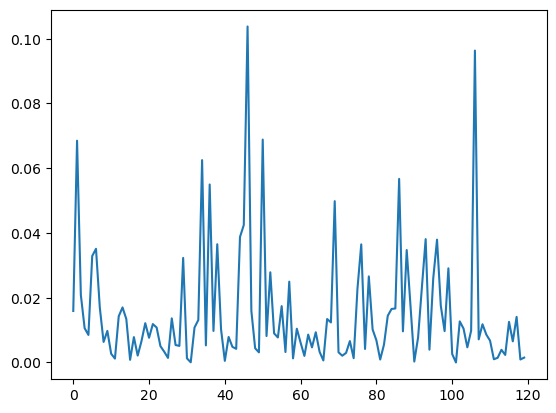

In [100]:
plt.plot(range(len(rel_error_mc)), rel_error_mc)

In [64]:
stat_errors = np.array([np.sqrt((1-p)/p)/np.sqrt(N) for p in venn_values_sample[no_zero]])

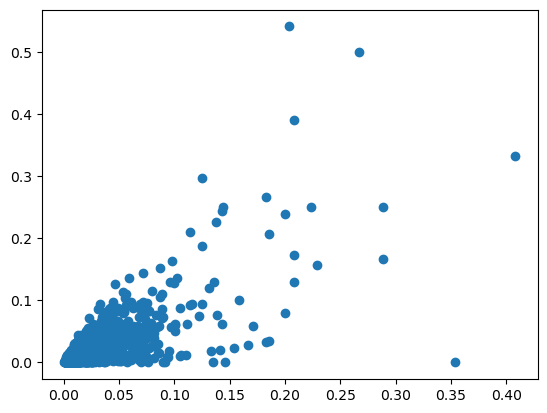

In [65]:
plt.scatter( stat_errors, rel_error_mc)

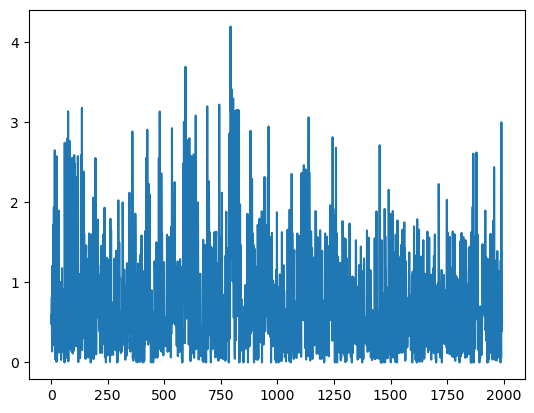

In [34]:
plt.plot(range(len(rel_error_mc)), rel_error_mc/stat_errors)

In [35]:
ratio = (rel_error_mc/stat_errors)
ratio.mean(), ratio.std()

(0.7737127967837142, 0.6871763001474214)

In [36]:
np.corrcoef(stat_errors, rel_error_mc)

array([[1.        , 0.73338743],
       [0.73338743, 1.        ]])

In [138]:
lr = LinearRegression()
lr.fit(stat_errors.reshape(-1,1), rel_error_mc)

LinearRegression()

In [139]:
lr.coef_

array([0.74794121])

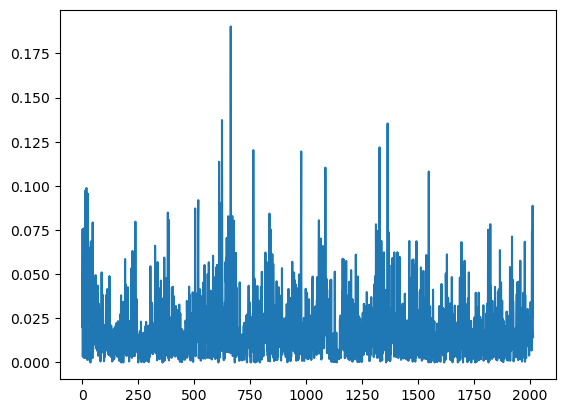

In [114]:
plt.plot(range(len(rel_error_mc)), rel_error_mc)